# Spatial mapping of cell types across the mouse brain (2/3) - cell2location

This notebook demonstrates how to use the **cell2location** model for mapping a single cell reference cell types onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain ([Kleshchevnikov et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1)). 

The first step of our model (#2 in Fig 1, tutorial 1/3) is to estimate reference cell type signatures from scRNA-seq profiles, for example as obtained using conventional clustering to identify cell types and subpopulations followed by estimation of average cluster gene expression profiles ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). Cell2location implements this estimation step based on Negative Binomial regression, which allows to robustly combine data across technologies and batches ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf)).

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*


In the second step covered by this notebook (#4 in Fig 1), cell2location decomposes mRNA counts in spatial transcriptomic data using these reference signatures, thereby estimating the relative and absolute abundance of each cell type at each spatial location ([Suppl. Methods, Section 1](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). 

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3)

II. Spatially mapping cell types (2/3, this notebook):

1. [Loading Visium data, QC](#1.-Loading-Visium-data)
2. [Visualise Visium data in spatial 2D and UMAP coordinates](#2.-Visualise-Visium-data-in-spatial-2D-and-UMAP-coordinates)
3. [Load reference cell type signature from snRNA-seq data and show UMAP of cells](#3.-Load-reference-cell-type-signature-from-snRNA-seq-data-and-show-UMAP-of-cells)
4. [Cell2location model description and analysis pipeline](#4.-Cell2location-model-description-and-analysis-pipeline),
[Evaluating training](#Evaluating-training)

III. Results and downstream analysis (3/3)


## Loading packages and setting up GPU

First, we need to load the relevant packages and tell cell2location to use the GPU. cell2location is written in pymc3 language for probabilistic modelling that uses a deep learning library called theano for heavy computations. While the package works on both GPU and CPU, using the GPU significantly shortens the computation time for 10X Visium datasets. Using the CPU is more feasible for smaller datasets with fewer spatial locations (e.g. Nanostring WTA technology). 

In [1]:
import sys
import time
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## 1. Loading Visium data <a name="1.-Loading-Visium-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, we need to download and unzip spatial data, as well as download estimated signatures of reference cell types, from our data portal:

In [18]:
# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
annotations_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/tissue_annotation/oxford/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

run_name = f'{results_folder}oxford/seurat/'

regression_model_output = 'RegressionGeneBackgroundCoverageGeneTechnologyTorch_168covariates_153901cells_14388genespaediatric_adult'
reg_path = f'{sc_results_folder}regression_model/{regression_model_output}/'

Now, let's read the spatial Visium data from the 10X Space Ranger output and examine several QC plots. Here, we load the our Visium mouse brain experiments (i.e. sections) and corresponding histology images into a single anndata object `adata`.

In [3]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.DataFrame(['A1', 'A2'], 
                           columns=['sample_name'])

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<div class="alert alert-block alert-danger">
<b>Note!</b>
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [4]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
# read histology-based annotations:
adata.obs['Annotation'] = ''

for s in adata.obs['sample'].unique():
    annot_ = pd.read_csv(f'{annotations_folder}{s}_annotation.csv', index_col='Barcode')
    annot_.index = [f'{s}_{i}' for i in annot_.index]
    
    adata.obs.loc[annot_.index, 'Annotation'] = annot_['Annotation']
    
adata.obs['Annotation'].value_counts(dropna=False)

Trying to set attribute `.obs` of view, copying.


Epithelial            1752
Other_tissue          1649
NaN                    596
LowQ_tissue            527
Stem_cell_zone         396
Lymphoid_structure      45
Name: Annotation, dtype: int64

In [6]:
# select locations from good quality tissue:
tissue_ind = adata.obs['Annotation'].isin(['Stem_cell_zone', 'Epithelial',
                                           'Other_tissue', 'Lymphoid_structure'])
print(sum(tissue_ind))

adata = adata[tissue_ind, :]
adata.obs['Annotation'].value_counts(dropna=False)

3842


Epithelial            1752
Other_tissue          1649
Stem_cell_zone         396
Lymphoid_structure      45
Name: Annotation, dtype: int64

### Look at QC metrics

Now let's look at QC: total number of counts and total number of genes per location across Visium experiments.

Trying to set attribute `.uns` of view, copying.
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated funct

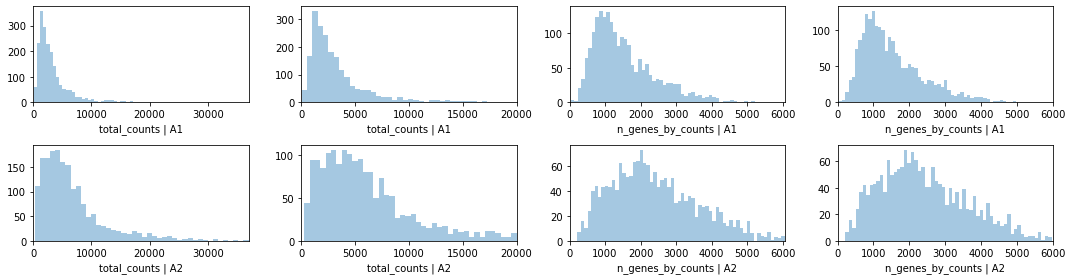

In [7]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')
    
    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')
    
plt.tight_layout()

## 2. Visualise Visium data in spatial 2D and UMAP coordinates <a name="2.-Visualise-Visium-data-in-spatial-2D-and-UMAP-coordinates"></a>

### Visualising data in spatial coordinates with scanpy

Next, we show how to plot these QC values over the histology image using standard scanpy tools

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


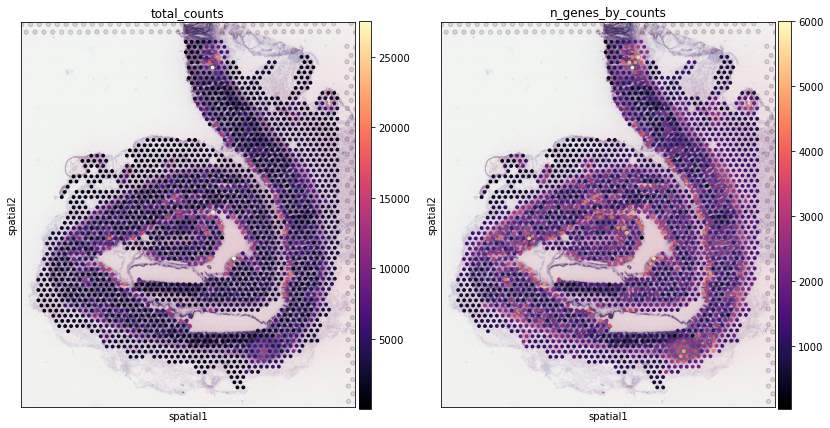

In [8]:
slide = select_slide(adata, 'A1')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma', 
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

Here we show how to use scanpy to plot the expression of individual genes without the histology image.

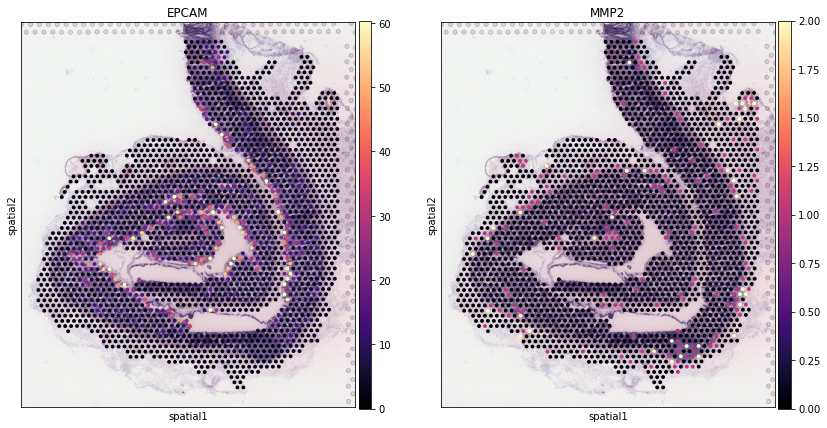

In [9]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, 
                  color=["EPCAM", "MMP2"], #img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


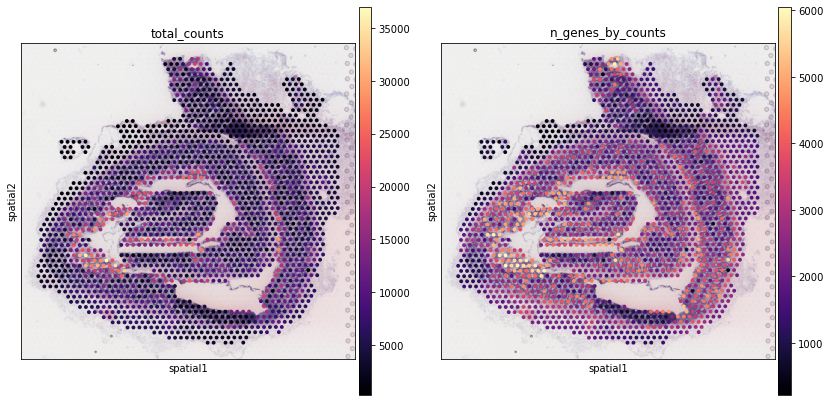

In [10]:
slide = select_slide(adata, 'A2')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma', 
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

Here we show how to use scanpy to plot the expression of individual genes without the histology image.

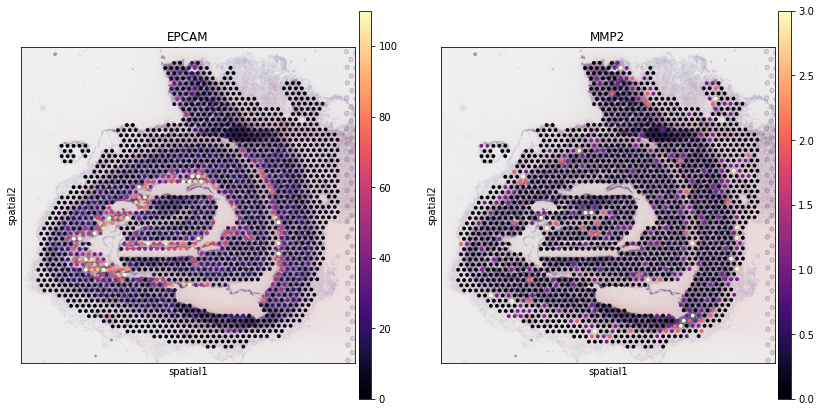

In [11]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, 
                  color=["EPCAM", "MMP2"], #img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

Add counts matrix as `adata.raw` 

In [12]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [19]:
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

#adata_snrna_raw2 = anndata.read_h5ad(sc_data_folder + "FINAL_OBJECT_raw_nosoupx.h5ad")
#adata_snrna_raw.obsm = adata_snrna_raw2[adata_snrna_raw.obs_names,:].obsm

In [20]:
# Column name containing cell type annotations
covariate_col_names = 'Integrated_05'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [21]:
inf_aver

Activated CD4 T  Activated CD8 T    Adult Glia  \
ENSG00000187634     1.882720e-05     2.652420e-11  4.429735e-03   
ENSG00000188976     4.522706e-02     5.451193e-02  3.153365e-02   
ENSG00000187583     1.888670e-03     1.131201e-02  1.043881e-10   
ENSG00000188290     3.453809e-02     5.549888e-02  1.038881e-01   
ENSG00000187608     9.490387e-02     2.390470e-01  1.965342e-01   
...                          ...              ...           ...   
ENSG00000277196     1.965705e-11     2.772210e-11  8.631742e-03   
ENSG00000276345     1.688571e-06     1.481558e-05  8.916428e-06   
ENSG00000277856     2.065677e-04     2.452418e-06  2.573400e-10   
ENSG00000275063     1.479292e-03     1.359615e-05  2.286915e-05   
ENSG00000271254     2.606655e-04     1.691514e-03  3.067226e-03   

                 BEST2+ Goblet cell  BEST4+ epithelial      CD8 Tmem  \
ENSG00000187634            0.001082       8.692744e-04  2.912760e-04   
ENSG00000188976            0.202993       1.248856e-01  5.221623e-02   
ENSG00000187583            0.005765       3.720456e-04  4.439093e-03   
ENSG00000188290            0.114334       1.924141e+00  1.207467e-03   
ENSG00000187608            0.135406       1.018043e+00  1.566707e-01   
...                             ...                ...           ...   
ENSG00000277196            0.001368       6.965077e-03  4.414658e-05   
ENSG00000276345            0.001045       1.250919e-04  1.094584e-04   
ENSG00000277856            0.000003       3.317648e-07  6.977834e-11   
ENSG00000275063            0.000026       2.531415e-04  5.496587e-11   
ENSG00000271254            0.044385       3.559867e-02  2.084759e-04   

                 CX3CR1+ CD8 Tmem    Colonocyte  Contractile pericyte (PLN+)  \
ENSG00000187634      2.616255e-10  4.241040e-06                 1.136024e-04   
ENSG00000188976      6.573176e-02  1.291353e-01                 7.783988e-02   
ENSG00000187583      1.215480e-02  1.209551e-03                 1.167786e-03   
ENSG00000188290      2.338955e-10  6.188532e-02                 4.587264e+00   
ENSG00000187608      2.242056e-01  4.216200e-01                 5.422467e-01   
...                           ...           ...                          ...   
ENSG00000277196      2.005941e-10  6.714917e-03                 1.021763e-05   
ENSG00000276345      7.243169e-05  5.522605e-04                 5.709608e-11   
ENSG00000277856      3.036130e-10  1.145456e-07                 1.034208e-06   
ENSG00000275063      1.472751e-05  4.005664e-06                 2.615031e-03   
ENSG00000271254      2.499526e-10  7.482690e-02                 8.309532e-03   

                 Cycling B cell  ...          Tuft  arterial capillary  \
ENSG00000187634    9.293516e-05  ...  7.080153e-11            0.002839   
ENSG00000188976    2.196514e-01  ...  6.296619e-02            0.062890   
ENSG00000187583    1.364869e-03  ...  6.859322e-11            0.000115   
ENSG00000188290    2.005227e-03  ...  1.593832e-02            0.257067   
ENSG00000187608    2.298813e-01  ...  1.222530e-01            0.713583   
...                         ...  ...           ...                 ...   
ENSG00000277196    6.381664e-11  ...  3.119004e-03            0.008315   
ENSG00000276345    2.476775e-03  ...  3.526487e-04            0.000008   
ENSG00000277856    9.010558e-03  ...  1.852247e-06            0.000047   
ENSG00000275063    1.331202e+00  ...  6.677288e-06            0.000145   
ENSG00000271254    1.917460e-03  ...  6.948762e-03            0.020338   

                         cDC1          cDC2           gdT  mLN Stroma (FMO2+)  \
ENSG00000187634  2.168323e-10  7.299997e-11  3.634360e-11        3.839578e-02   
ENSG00000188976  1.229476e-01  7.557978e-02  1.005446e-01        1.671037e-01   
ENSG00000187583  2.199184e-02  2.674127e-05  1.492436e-02        1.257538e-10   
ENSG00000188290  1.931127e-03  4.500726e-02  1.379606e-01        4.638556e-02   
ENSG00000187608  3.838508e-01  1.680820e-01  3.089194e-01        9.707356e-02   
...        

### Read Seurat results

In [22]:
run_name

'/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/oxford/seurat/'

In [23]:
seurat = pd.read_csv(f'{run_name}results_selected_76clusters_pca.csv', index_col=0)
seurat = seurat.drop(columns=['predicted.id', 'spot', 'prediction.score.max'])

from re import sub
seurat.columns = [sub('prediction\.score\.', '', i) for i in seurat.columns]

def remove_special_characters(df, special_list=[' ', '\(', '\)', '\+', '\\\\', '/', '-', ';'],
                              replace='.'):
    from re import sub
    for s in special_list:
        df.columns = [sub(s, replace, c) for c in df.columns]
            
    return df

inf_aver_copy = inf_aver.copy()
inf_aver_copy = remove_special_characters(inf_aver_copy)

seurat = seurat[inf_aver_copy.columns]
seurat.columns = inf_aver.columns
seurat

Activated CD4 T  Activated CD8 T  Adult Glia  \
A1_AAACAAGTATCTCCCA-1                0                0         0.0   
A1_AAACAGAGCGACTCCT-1                0                0         0.0   
A1_AAACATTTCCCGGATT-1                0                0         0.0   
A1_AAACCACTACACAGAT-1                0                0         0.0   
A1_AAACCCGAACGAAATC-1                0                0         0.0   
...                                ...              ...         ...   
A2_TTGTGTATGCCACCAA-1                0                0         0.0   
A2_TTGTGTTTCCCGAAAG-1                0                0         0.0   
A2_TTGTTGTGTGTCAAGA-1                0                0         0.0   
A2_TTGTTTCACATCCAGG-1                0                0         0.0   
A2_TTGTTTCCATACAACT-1                0                0         0.0   

                       BEST2+ Goblet cell  BEST4+ epithelial  CD8 Tmem  \
A1_AAACAAGTATCTCCCA-1            0.000000           0.000000         0   
A1_AAACAGAGCGACTCCT-1            0.875515           0.000000         0   
A1_AAACATTTCCCGGATT-1            0.000000           0.000000         0   
A1_AAACCACTACACAGAT-1            0.697839           0.000000         0   
A1_AAACCCGAACGAAATC-1            0.497789           0.000000         0   
...                                   ...                ...       ...   
A2_TTGTGTATGCCACCAA-1            0.663727           0.000000         0   
A2_TTGTGTTTCCCGAAAG-1            0.673857           0.000000         0   
A2_TTGTTGTGTGTCAAGA-1            0.695081           0.000000         0   
A2_TTGTTTCACATCCAGG-1            0.865277           0.093729         0   
A2_TTGTTTCCATACAACT-1            0.401616           0.000000         0   

                       CX3CR1+ CD8 Tmem  Colonocyte  \
A1_AAACAAGTATCTCCCA-1                 0    0.000000   
A1_AAACAGAGCGACTCCT-1                 0    0.034260   
A1_AAACATTTCCCGGATT-1                 0    0.000000   
A1_AAACCACTACACAGAT-1                 0    0.075853   
A1_AAACCCGAACGAAATC-1                 0    0.211775   
...                                 ...         ...   
A2_TTGTGTATGCCACCAA-1                 0    0.134702   
A2_TTGTGTTTCCCGAAAG-1                 0    0.090341   
A2_TTGTTGTGTGTCAAGA-1                 0    0.074789   
A2_TTGTTTCACATCCAGG-1                 0    0.000000   
A2_TTGTTTCCATACAACT-1                 0    0.000000   

                       Contractile pericyte (PLN+)  Cycling B cell  ...  Tuft  \
A1_AAACAAGTATCTCCCA-1                     0.194481             0.0  ...   0.0   
A1_AAACAGAGCGACTCCT-1                     0.000000             0.0  ...   0.0   
A1_AAACATTTCCCGGATT-1                     0.129195             0.0  ...   0.0   
A1_AAACCACTACACAGAT-1                     0.000000             0.0  ...   0.0   
A1_AAACCCGAACGAAATC-1                     0.000000             0.0  ...   0.0   
...                                            ...             ...  ...   ...   
A2_TTGTGTATGCCACCAA-1                     0.000000             0.0  ...   0.0   
A2_TTGTGTTTCCCGAAAG-1                     0.000000             0.0  ...   0.0   
A2_TTGTTGTGTGTCAAGA-1                     0.000000             0.0  ...   0.0   
A2_TTGTTTCACATCCAGG-1                     0.000000             0.0  ...   0.0   
A2_TTGTTTCCATACAACT-1                     0.000000             0.0  ...   0.0   

                       arterial capillary  cDC1  cDC2  gdT  \
A1_AAACAAGTATCTCCCA-1                 0.0     0     0    0   
A1_AAACAGAGCGACTCCT-1                 0.0     0     0    0   
A1_AAACATTTCCCGGATT-1                 0.0     0     0    0   
A1_AAACCACTACACAGAT-1                 0.0     0     0    0   
A1_AAACCCGAACGAAATC-1                 0.0     0     0    0   
...                                   ...   ...   ...  ...   
A2_TTGTGTATGCCACCAA-1                 0.0     0     0    0   
A2_TTGTGTTTCCCGAAAG-1                 0.0     0     0    0   
A2_TTGTTGTGTGTCAAGA-1                 0.0     0     0    0   
A2_TTGTTTCACATCCAGG-1      

In [24]:
seurat

Activated CD4 T  Activated CD8 T  Adult Glia  \
A1_AAACAAGTATCTCCCA-1                0                0         0.0   
A1_AAACAGAGCGACTCCT-1                0                0         0.0   
A1_AAACATTTCCCGGATT-1                0                0         0.0   
A1_AAACCACTACACAGAT-1                0                0         0.0   
A1_AAACCCGAACGAAATC-1                0                0         0.0   
...                                ...              ...         ...   
A2_TTGTGTATGCCACCAA-1                0                0         0.0   
A2_TTGTGTTTCCCGAAAG-1                0                0         0.0   
A2_TTGTTGTGTGTCAAGA-1                0                0         0.0   
A2_TTGTTTCACATCCAGG-1                0                0         0.0   
A2_TTGTTTCCATACAACT-1                0                0         0.0   

                       BEST2+ Goblet cell  BEST4+ epithelial  CD8 Tmem  \
A1_AAACAAGTATCTCCCA-1            0.000000           0.000000         0   
A1_AAACAGAGCGACTCCT-1            0.875515           0.000000         0   
A1_AAACATTTCCCGGATT-1            0.000000           0.000000         0   
A1_AAACCACTACACAGAT-1            0.697839           0.000000         0   
A1_AAACCCGAACGAAATC-1            0.497789           0.000000         0   
...                                   ...                ...       ...   
A2_TTGTGTATGCCACCAA-1            0.663727           0.000000         0   
A2_TTGTGTTTCCCGAAAG-1            0.673857           0.000000         0   
A2_TTGTTGTGTGTCAAGA-1            0.695081           0.000000         0   
A2_TTGTTTCACATCCAGG-1            0.865277           0.093729         0   
A2_TTGTTTCCATACAACT-1            0.401616           0.000000         0   

                       CX3CR1+ CD8 Tmem  Colonocyte  \
A1_AAACAAGTATCTCCCA-1                 0    0.000000   
A1_AAACAGAGCGACTCCT-1                 0    0.034260   
A1_AAACATTTCCCGGATT-1                 0    0.000000   
A1_AAACCACTACACAGAT-1                 0    0.075853   
A1_AAACCCGAACGAAATC-1                 0    0.211775   
...                                 ...         ...   
A2_TTGTGTATGCCACCAA-1                 0    0.134702   
A2_TTGTGTTTCCCGAAAG-1                 0    0.090341   
A2_TTGTTGTGTGTCAAGA-1                 0    0.074789   
A2_TTGTTTCACATCCAGG-1                 0    0.000000   
A2_TTGTTTCCATACAACT-1                 0    0.000000   

                       Contractile pericyte (PLN+)  Cycling B cell  ...  Tuft  \
A1_AAACAAGTATCTCCCA-1                     0.194481             0.0  ...   0.0   
A1_AAACAGAGCGACTCCT-1                     0.000000             0.0  ...   0.0   
A1_AAACATTTCCCGGATT-1                     0.129195             0.0  ...   0.0   
A1_AAACCACTACACAGAT-1                     0.000000             0.0  ...   0.0   
A1_AAACCCGAACGAAATC-1                     0.000000             0.0  ...   0.0   
...                                            ...             ...  ...   ...   
A2_TTGTGTATGCCACCAA-1                     0.000000             0.0  ...   0.0   
A2_TTGTGTTTCCCGAAAG-1                     0.000000             0.0  ...   0.0   
A2_TTGTTGTGTGTCAAGA-1                     0.000000             0.0  ...   0.0   
A2_TTGTTTCACATCCAGG-1                     0.000000             0.0  ...   0.0   
A2_TTGTTTCCATACAACT-1                     0.000000             0.0  ...   0.0   

                       arterial capillary  cDC1  cDC2  gdT  \
A1_AAACAAGTATCTCCCA-1                 0.0     0     0    0   
A1_AAACAGAGCGACTCCT-1                 0.0     0     0    0   
A1_AAACATTTCCCGGATT-1                 0.0     0     0    0   
A1_AAACCACTACACAGAT-1                 0.0     0     0    0   
A1_AAACCCGAACGAAATC-1                 0.0     0     0    0   
...                                   ...   ...   ...  ...   
A2_TTGTGTATGCCACCAA-1                 0.0     0     0    0   
A2_TTGTGTTTCCCGAAAG-1                 0.0     0     0    0   
A2_TTGTTGTGTGTCAAGA-1                 0.0     0     0    0   
A2_TTGTTTCACATCCAGG-1      

In [25]:
adata_vis = adata_vis[adata_vis.obs_names.isin(seurat.index), :]

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [26]:
import pandas as pd
adata_vis.obsm["decomposition"] = seurat
for ct in adata_vis.obsm["decomposition"].columns:
    adata_vis.obs[ct] = adata_vis.obsm["decomposition"][ct]
    
#adata_vis.write(f"{results_folder}seurat/sp.h5ad")

Trying to set attribute `.uns` of view, copying.
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical
Trying to set attribute `.uns` of view, copying.
... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


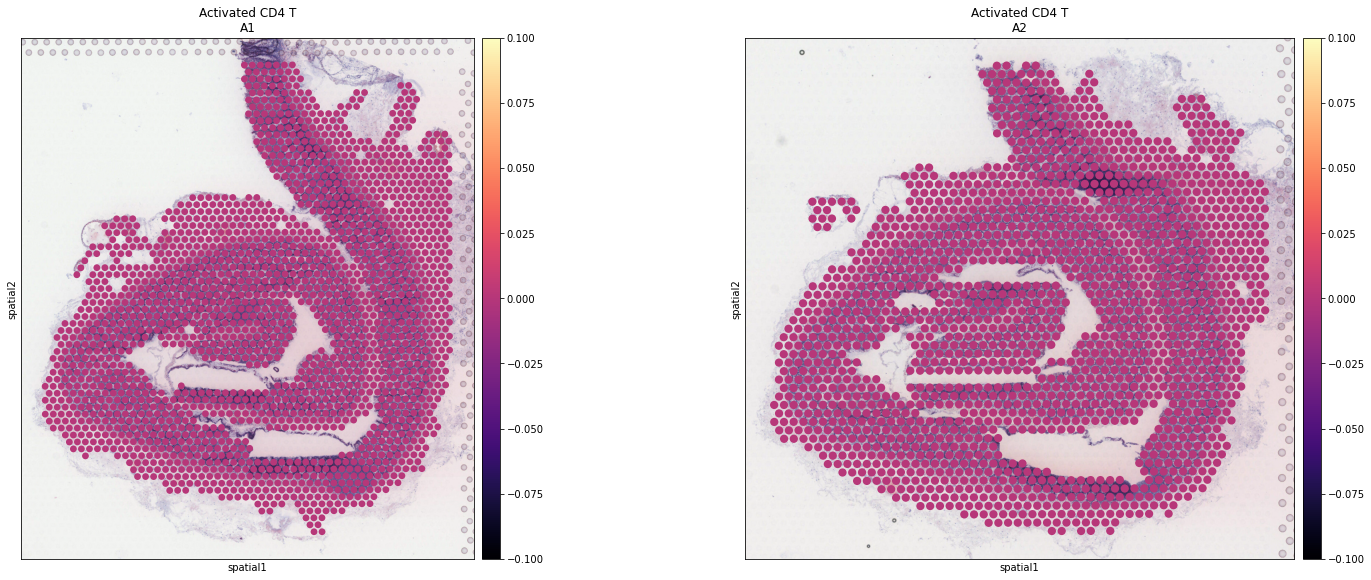

In [27]:
def plot_spatial_per_cell_type(adata, 
                               cell_type=adata_vis.obsm["decomposition"].columns,
                               samples=['A1', 'A2'],
                              ncol=2):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(24, 8))
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, 0.992)
    #adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type=adata_vis.obsm["decomposition"].columns[0]);

In [28]:
import os
with mpl.rc_context({"axes.facecolor": "black"}):
    clust_names = adata_vis.obsm["decomposition"].columns
    
    for s in adata_vis.obs['sample'].unique():

        s_ind = adata_vis.obs['sample'] == s
        s_keys = list(adata_vis.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

        fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                            color=clust_names, ncols=5, library_id=s_spatial,
                            size=1.3, img_key='hires', alpha_img=1,
                            vmin=0, vmax='p99.2',
                            return_fig=True, show=False)
        
        fig_dir = f"{run_name}/spatial/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig_dir = f"{run_name}/spatial/per_sample/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)

        plt.savefig(f"{fig_dir}W_cell_abundance_q05_{s}.png",
                    bbox_inches='tight')
        plt.close()

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Annotation' as categorical
Trying to set attribute `.var`

In [29]:
decomposition = adata_vis.obs[adata_vis.obsm["decomposition"].columns]
decomposition = (decomposition.T / decomposition.sum(1)).T
adata_vis.obs.loc[:, adata_vis.obsm["decomposition"].columns] = decomposition

with mpl.rc_context({"axes.facecolor": "black"}):
    clust_names = adata_vis.obsm["decomposition"].columns
    
    for s in adata_vis.obs['sample'].unique():

        s_ind = adata_vis.obs['sample'] == s
        s_keys = list(adata_vis.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

        fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                            color=clust_names, ncols=5, library_id=s_spatial,
                            size=1.3, img_key='hires', alpha_img=1,
                            vmin=0, vmax='p99.2',
                            return_fig=True, show=False)
        
        fig_dir = f"{run_name}/spatial/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig_dir = f"{run_name}/spatial/per_sample/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)

        plt.savefig(f"{fig_dir}W_cell_proportion_{s}.png",
                    bbox_inches='tight')
        plt.close()

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Annotation' as categorical
Trying to set attribute `.var`

## 4. Automatic discrete region identification by clustering cell densities
We find regions by clustering spots based on inferred molecule contributions of each cell type. We use leiden clustering that incorporates both the similarity of spots in cell locations and in their proximity, by including both when computing the KNN graph. Results are saved in `adata_vis.obs['leiden']`. Since the clustering is done jointly, the cluster identities match between sections.

In [30]:
# compute KNN using the cell2location output
adata_vis.obsm['decomposition_proportion'] = adata_vis.obs.loc[:, adata_vis.obsm["decomposition"].columns]
sc.pp.neighbors(adata_vis, use_rep='decomposition_proportion',
                n_neighbors = 20, metric='correlation')

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.7)

adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] = adata_vis.obs["region_cluster"].astype("category")


... storing 'Annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


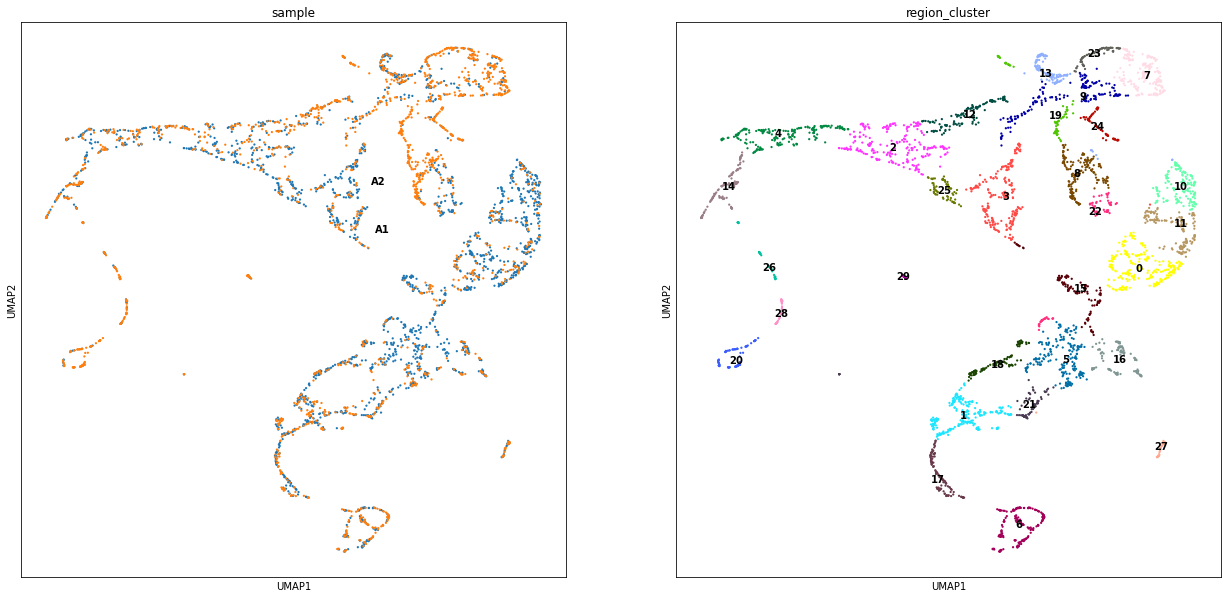

In [31]:
sc.tl.umap(adata_vis, min_dist = 0.2, spread = 1.5)

sc.settings.figdir = f"{run_name}/"

#del adata_vis.uns['region_cluster_colors']

rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['sample', 'region_cluster'],
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=10, size=20, save='umap_region_cluster.pdf')

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


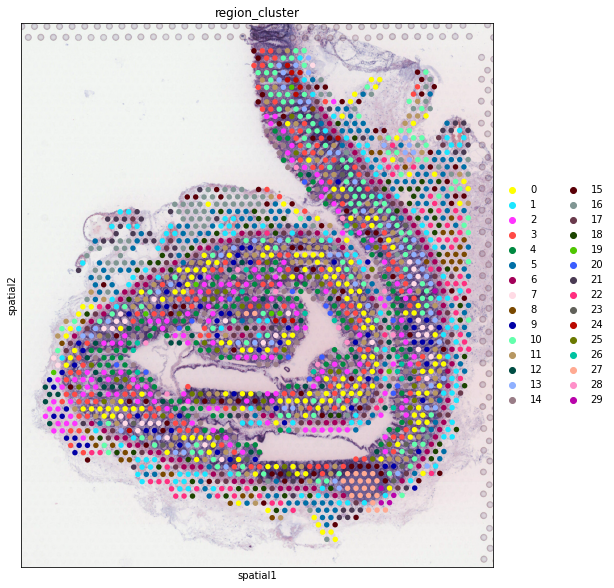

Trying to set attribute `.uns` of view, copying.


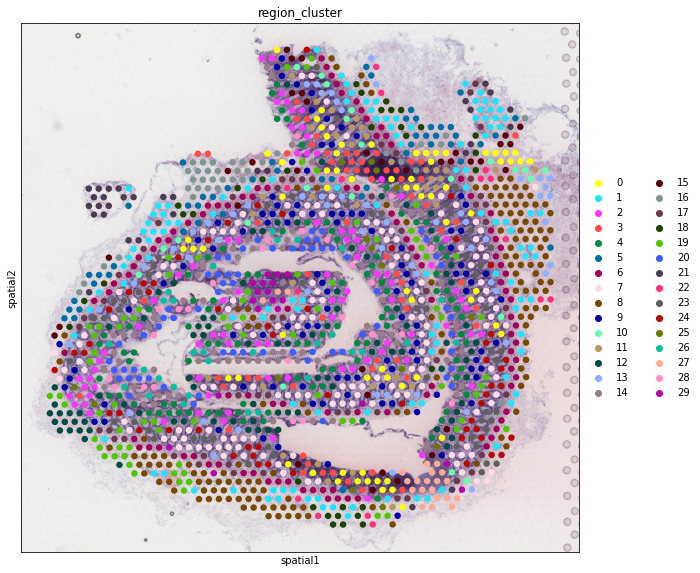

In [32]:
# Plot locations of clusters
rcParams["figure.figsize"] = [10, 10]
rcParams["axes.facecolor"] = "white"

for s in list(adata_vis.obs["sample"].unique()):
    slide = select_slide(adata_vis, s)
    sel_clust = adata_vis.obs['region_cluster'].cat.categories.isin(slide.obs['region_cluster'].cat.categories)
    slide.uns['region_cluster_colors'] = list(np.array(adata_vis.uns['region_cluster_colors'])[sel_clust])
    sc.pl.spatial(slide, #library_id=s,
                  color=["region_cluster"], img_key='hires', size=1,
                  #palette=adata_vis.uns['region_cluster_colors']
                );

### Export regions for import to 10X Loupe Browser
# add binary labels for each region
region_cluster_bin = adata_vis.obs[['region_cluster']]
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])

for i in np.unique(sam):
    
    s1 = region_cluster_bin
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'
    
    s1.to_csv(run_name +'/region_cluster29_' + i + '.csv')

## 6. Identify co-occuring cell type combinations using matrix factorisation

Here we use inferred cell densities as input to non-negative matrix factorisation to identify co-occuring cell type combinations.

Modules and their versions used for this analysis

In [33]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.22.0
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
IPython.core.magics.code 7.22.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_de